## Horizons and attributes

After [a question about attributes](http://earthscience.stackexchange.com/questions/5023/how-do-i-extract-seismic-amplitude-on-an-interpreted-horizon) on Earth Science Stack Exchange, I made a couple of illustrations for a blog post on the subject, *[An attribute analysis primer](http://agilegeoscience.com/blog/2015/6/26/an-attribute-analysis-primer)*. I want to show three things for now:

* Different types of surface or window to use for attribute extraction.
* The importance of interpolation type in extracting attributes at arbitrary time locations. 
* The range of different statistics one can extract over a window.

First, the usual imports.

You can play with all of the examples in this tutorial yourself in the notebook and data at https://github.com/seg. Please refer to the tutorial in the January 2016 issue for help getting started. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We're going to read amplitudes from in between samples on a seismic trace. We need an interpolator.

In [2]:
from scipy.interpolate import interp1d

Now we can make a tiny toy example, to illustrate the point.

In [3]:
# Make a 'trace' of amplitudes.
amps = np.array([0,1,3,0,-2,-5,-2,2,5,0])

# Give the trace a time basis.
time = np.linspace(0, 18, amps.size)
print(time)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.]


Make an interpolator function, then call it for some time that does not have a sample associated with it.

In [4]:
f = interp1d(time, amps, kind='linear')
print(f(3.1415926))

2.1415926


Here's the situation as a figure:

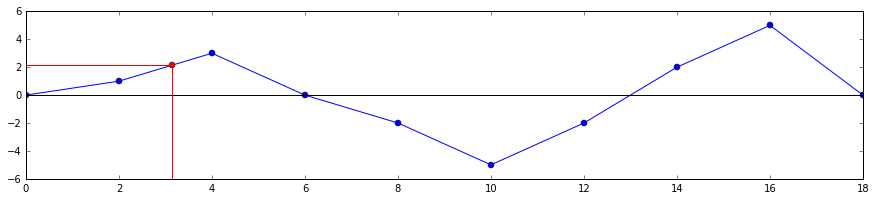

In [5]:
x, y = 3.14159, f(3.14159)
plt.figure(figsize=(15, 3))
plt.plot(time, amps, 'o-')
plt.axhline(0, c='k')

# Plot our point.
plt.plot(x, y, 'ro')
plt.axvline(x, ymin=0, ymax=(6+y)/12, c='r')
plt.axhline(y, xmin=0, xmax=x/18, c='r')
plt.show()

Let's implement this in a bigger example and make an even nicer figure!

<hr />
## Different measures of amplitude at a given *t*

A horizon can cross a trace at any time *t* (within the precision of the horizon's TWT property). But a seismic trace only has samples at discrete times. So how do we determine the amplitude at arbitrary times on the trace? Interpolation!

In [6]:
trace = np.array([0,1,3,0,-2,-5,-2,2,5,0,-1,1,0,3,3,-1,-3,-5,-1,0])

Let's choose an arbitrary place to measure amplitude, making sure it's not right on a sample.

In [7]:
horizon = 7.544  # No units, it's just a sort of fractional index.

In [8]:
def read_amp(trace, time, method='linear'):
    """Wraps ``interp1d``.
    """
    indices = np.arange(trace.size)
    
    # Create the interpolation function, f.
    f = interp1d(indices, trace, kind=method, assume_sorted=True)
    
    return f(time)

In [9]:
hor_spline = read_amp(trace, horizon, method='cubic')
print(hor_spline)

4.417311557225109


In [10]:
hor_linear = read_amp(trace, horizon, method='linear')
print(hor_linear)

3.631999999999999


In [11]:
zero_order = read_amp(trace, horizon, method='zero')
print(zero_order)

2.0


In [12]:
# Set up basis vectors
x = np.arange(trace.size)
t = np.linspace(0, trace.size-1, 2000)
amp_spline = read_amp(trace, t, method='cubic')
amp_linear = read_amp(trace, t, method='linear')
amp_nearest = read_amp(trace, t, method='nearest')

In [13]:
%timeit read_amp(trace, t, method='cubic')
%timeit read_amp(trace, t, method='linear')
%timeit read_amp(trace, t, method='nearest')

1000 loops, best of 3: 560 µs per loop
10000 loops, best of 3: 152 µs per loop
10000 loops, best of 3: 111 µs per loop


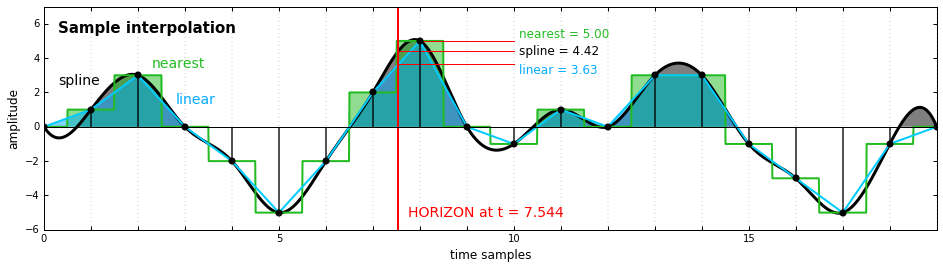

In [14]:
styles = {'ha':'left', 'va':'center', 'size':14}
fig = plt.figure(figsize=(16,4))

#ax = fig.add_axes([0.05,0.15,0.825,0.75])
ax = fig.add_subplot(111)

# Fix some types
hor_spline = float(hor_spline)
hor_linear = float(hor_linear)
zero_order = float(zero_order)

# Samples
ax.scatter(x, trace, s=50, c='k', lw=0, zorder=10)
for i, v in enumerate(trace):
    adj = 0.01
    if v > 0:
        ax.axvline(x=i, ymin=6/13, ymax=6/13 + v/13., c='k', alpha=0.67, lw=2, zorder=9)
    else:
        ax.axvline(x=i, ymin=6/13 + v/13., ymax=6/13-adj, c='k', alpha=0.67, lw=2, zorder=9)

# Spline interpolated
ax.plot(t, amp_spline, 'k', lw=3)
ax.fill_between(t, 0, amp_spline, where=amp_spline>0, color='k', alpha=0.5, lw=0)
ax.text(0.3, 2.7, "spline", color='k', **styles)

# Nearest interpolated
ax.plot(t, amp_nearest, '#22bb22', lw=2)
ax.fill_between(t, 0, amp_nearest, where=amp_nearest>0, color='#22bb22', alpha=0.5, lw=0)
ax.text(2.3, 3.7, "nearest", color='#22bb22', **styles)

# Linear interpolated
ax.plot(t, amp_linear, '#00ccff', lw=2)
ax.fill_between(t, 0, amp_linear, where=amp_linear>0, color='#00aaff', alpha=0.5, lw=0)
ax.text(2.8, 1.6, "linear", color='#00aaff', **styles)

# Horizon crossing point and amplitudes
pos = 10.1
ax.axvline(x=horizon, c='r', lw=2)
ax.text(horizon+0.2, -5, "HORIZON at t = {}".format(horizon), color='r', **styles)

styles = {'ha':'left', 'va':'center', 'size':12}
ax.axhline(y=5, xmin=8/19., xmax=10/19, c='r', lw=1)
ax.axhline(y=hor_spline, xmin=horizon/19., xmax=10/19, c='r', lw=1)
ax.axhline(y=hor_linear, xmin=horizon/19., xmax=10/19, c='r', lw=1)
#ax.axhline(y=zero_order, xmin=7/19., xmax=10/19, c='r', lw=1)
ax.text(pos, 5+0.4, "nearest = {:.2f}".format(5), color='#22bb22', **styles)
ax.text(pos, hor_spline, "spline = {:.2f}".format(hor_spline), color='k', **styles)
ax.text(pos, hor_linear-0.3, "linear = {:.2f}".format(hor_linear), color='#00aaff', **styles)
#ax.text(pos, zero_order, "zero-order = {:.2f}".format(zero_order), color='k', **styles)

# Axes etc.
ax.text(0.3, 5.5, 'Sample interpolation', size=15, weight="bold")
ax.axhline(0, color='k')
ax.set_xlim(0, 19)
ax.set_ylim(-6, 7)
plt.xlabel('time samples', size=12)
plt.ylabel('amplitude', size=12)
plt.minorticks_on()
ax.tick_params(length=4, width=1, which='both')
ax.set_yscale('linear', subsx=np.arange(-6, 6, 2))  
plt.gca().xaxis.grid(True, which='both', lw=2, color='k', alpha=0.1)

# Save figure to your home directory.
import os
env = %env
plt.savefig(os.path.join(env['HOME'], "trace_sampling.png"), dpi=250)

# Show figure.
plt.show()

7.544 happens to be the position of the maximum 'energy' or magnitude of the complex trace...

In [15]:
import scipy.signal
h = scipy.signal.hilbert(trace)
print("Max magnitude:   {0:.2f}".format(np.amax(np.abs(h))))
print("Position of max: {0:.3f}".format(19. * (np.argmax(np.abs(h))/20000.)))

Max magnitude:   5.07
Position of max: 0.016


<hr />

# Real data

Inspired by Alessandro Amato del Monte's great notebook on amplitude extraction, we can apply some of what we've learned to real data. 

## Load the seismic data

If we're lucky, it's already been saved...

In [16]:
seismic = np.load('data/Penobscot_NumPy_.npy')

Or, to read from HDF5:

In [17]:
# import h5py
# h5f = h5py.File('data/Penobscot.h5','r')
# seismic = h5f['amplitude'][:]
# h5f.close()

If not, to read from SEG-Y, uncomment the following...

In [18]:
#import obspy
#filename = "data/Penobscot_0-1000ms.sgy"
#section = obspy.read(filename)  # This gives a list of traces
#data = np.dstack([d for d in section])
#seismic = np.squeeze(data).reshape((251, 601, 481))

To save in native NumPy format:

In [19]:
# np.save('data/Penobscot_NumPy.npy', seismic)

To save as HDF5:

In [20]:
# import h5py
# h5f = h5py.File('data/Penobscot.h5', 'w')
# h5f.create_dataset('amplitude', compression="gzip", data=seismic)
# h5f.close()

Check we got the data and it looks OK:

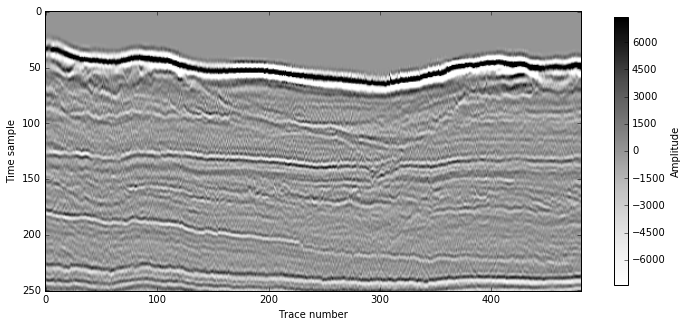

In [21]:
clip = np.percentile(seismic, 99)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.imshow(seismic[:,100,:], cmap="Greys", vmin=-clip, vmax=clip)
plt.colorbar(label="Amplitude", shrink=0.8)
ax.set_xlabel("Trace number")
ax.set_ylabel("Time sample")
plt.show()

## Load the horizon

Again, we might already have a horizon. Try this:

In [22]:
horizon = np.load('data/Penobscot_Seabed.npy')

If that worked, great — continue to the next section.

But if that file's not there, you'll have to load the text file...

In [23]:
horizon_data = np.loadtxt('data/Penobscot_Seabed.txt')
horizon_data[:5]

array([[ 1003.        ,  1067.        ,   155.92899919],
       [ 1003.        ,  1068.        ,   156.3333571 ],
       [ 1003.        ,  1069.        ,   157.37710893],
       [ 1003.        ,  1070.        ,   157.56893158],
       [ 1003.        ,  1071.        ,   160.05718708]])

The seismic volume's traces are implicitly numbered from zero, not with the true inline and crossline numbers. We could set up a 'lookup table' for the true trace numbers, but we'll keep things simple and just cast everything into this new, zero-based index. So we need to subtract 1000 from the inline and crossline numbers:

Now we'll read the 3rd column of the data into a new array, using the first two columns to tell us where to put them. First, we make an array of NaNs:

In [24]:
def regularize_horizon(horizon, extents, adj=(0,0)):
    output = np.empty(extents)
    output[:] = np.nan
    adj_x, adj_y = adj
    for (x, y, z) in horizon:
        output[int(x+adj_x), int(y+adj_y)] = z
    return output

In [25]:
sample_interval = 4  # ms
seabed = regularize_horizon(horizon_data, extents=(601, 481), adj=(-1000, -1000)) / sample_interval

In [26]:
seabed.shape

(601, 481)

We can optionally save this array to speed up loading later:

In [27]:
# np.save('data/Penobscot_Seabed.npy', seabed)

Now choose a horizon to work with for the rest of this notebook...

In [28]:
horizon = seabed.copy()

## Check the horizon looks OK

Make a quick plot of -1 &times; the seabed, as a quick way to get the colourbar the right way up:

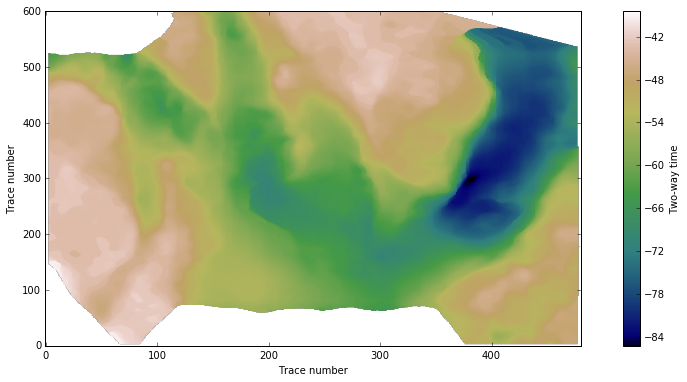

In [29]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.imshow(-horizon, aspect=0.5, cmap="gist_earth", origin='lower')
plt.colorbar(label="Two-way time")
ax.set_xlabel("Trace number")
ax.set_ylabel("Trace number")
plt.show()

## Extract amplitude on one line

In [30]:
line = 300

In [31]:
from matplotlib.font_manager import FontProperties

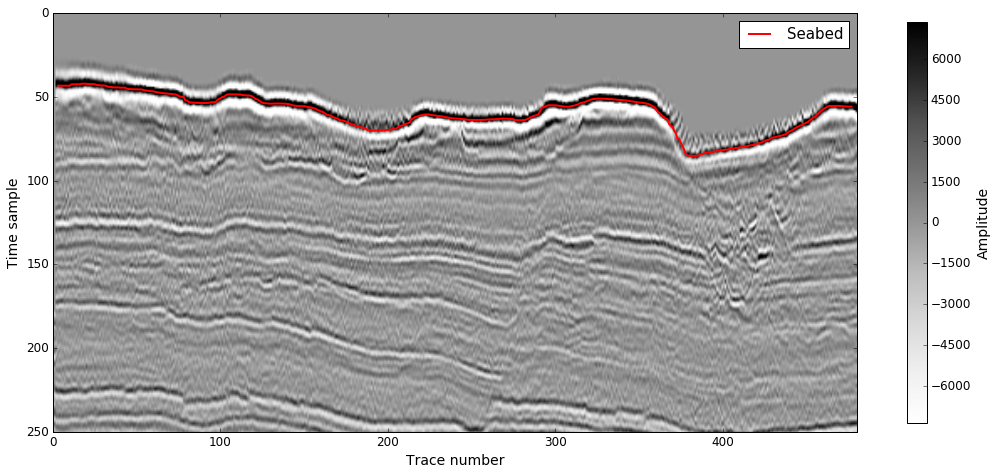

In [32]:
horizon[horizon==0] = np.nan

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
plt.imshow(seismic[:,line,:], cmap="Greys", vmin=-clip, vmax=clip)
plt.plot(horizon[line], label='Seabed', c='r', lw=2)

# Colourbar
cbar = plt.colorbar(label="Amplitude", shrink=0.9)
cbar.ax.tick_params(labelsize=12) 
text = cbar.ax.yaxis.label
font = FontProperties(size=14)
text.set_font_properties(font)

# Axes etc.
plt.legend(fontsize=15)
plt.xlim(0, 480)
plt.ylim(250, 0)
ax.set_xlabel("Trace number", size=14)
ax.set_ylabel("Time sample", size=14)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12) 
plt.show()

In [33]:
horizon[line][50]

45.400850474999999

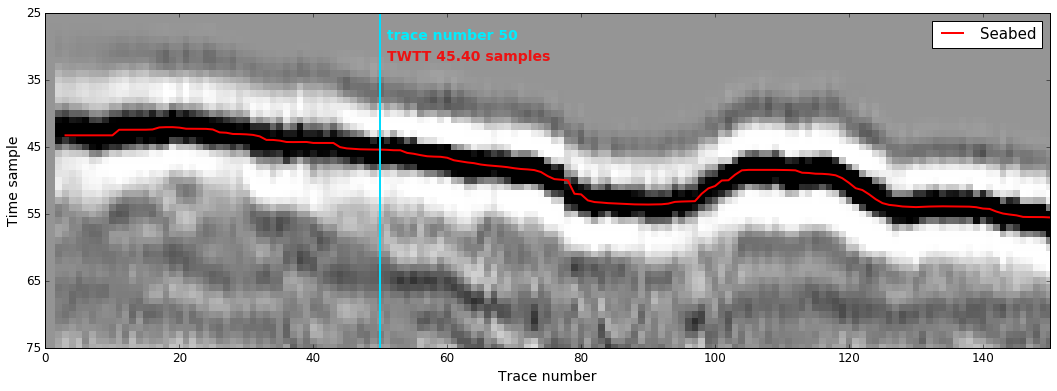

In [34]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
plt.imshow(seismic[25:76,line,:151], cmap="Greys", vmin=-clip, vmax=clip, interpolation='none')
ax.plot(horizon[line]-25, label='Seabed', c='r', lw=2)

# Vertical line
pos = 50
twt = horizon[line][pos]
ax.axvline(x=pos, c='#00ddff', lw=2)
ax.text(pos+1, 4, "trace number {}".format(pos), color='#00eeff', fontsize=14, fontweight='bold')
ax.text(pos+1, 7, "TWTT {:.2f} samples".format(twt), color='#ee1111', fontsize=14, fontweight='bold')

# Colourbar
# cbar = plt.colorbar(label="Amplitude", shrink=0.8)
# cbar.ax.tick_params(labelsize=12) 
# text = cbar.ax.yaxis.label
# font = FontProperties(size=14)
# text.set_font_properties(font)


# Axes etc.
plt.legend(fontsize=15)
plt.xlim(0, 150)
plt.ylim(50, 0)
ax.set_xlabel("Trace number", size=14)
ax.set_ylabel("Time sample", size=14)
plt.xticks(fontsize = 12) 
plt.yticks([0, 10, 20, 30, 40, 50], [25, 35, 45, 55, 65, 75])
plt.yticks(fontsize = 12) 

plt.savefig(os.path.join(env['HOME'], "seismic_horizon_segment.png"), dpi=250)
plt.show()

There is a nice interpolator in SciPy, `scipy.interpolate.interp1d` which gives us many options. We'll wrap this in some code to deal with shuffling our data around.

The options for `method` are

- **`'linear'`**, the default
- **`'nearest'`**
- **`'zero'`**, a zero order spline. Its value at any point is the last raw value seen.
- **`'slinear'`, `'quadratic'`, `'cubic'`** — a spline interpolation of first, second or third order
- **or an integer** specifying the order of the spline interpolator to use

We'll define a function for grabbing the amplitudes out of seismic traces in a 1D seismogram, a 2D line, or a 3D cube:

In [35]:
def get_amp(seismic, horizon, method="nearest"):
    # Deal with NaNs in the input and prepare the output.
    horizon[np.isnan(horizon)] = 0
    amps = np.zeros_like(horizon)
    amps[:] = np.nan
    
    # Iterate over traces and get the interpolated value.
    if seismic.ndim == 1:
        return read_amp(seismic, horizon, method)
    elif seismic.ndim == 2:
        # Treat like 2D
        for j, (trace, t) in enumerate(zip(seismic.T, horizon)):
            amps[j] = read_amp(trace, t, method)
    elif seismic.ndim == 3:
        # Treat like 3D
        for i, section in enumerate(np.swapaxes(seismic.T, 0, 1)):
            for j, (trace, t) in enumerate(zip(section, horizon[i])):
                amps[i, j] = read_amp(trace, t, method)
    else:
        raise Exception("Too many dimensions.")
 
    amps[amps==0] = np.nan
    return amps

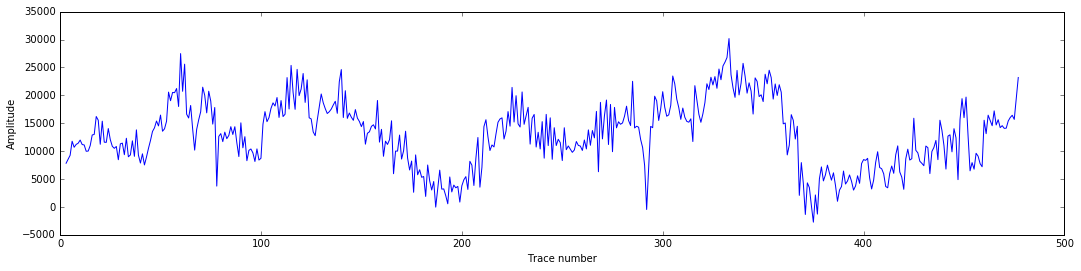

In [36]:
a = get_amp(seismic[:, line, :], horizon[line], method="nearest")
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.plot(a)
ax.set_xlabel("Trace number")
ax.set_ylabel("Amplitude")
plt.show()

## Extract amplitude on entire horizon

In [37]:
amp_full = get_amp(seismic, horizon, method="linear")

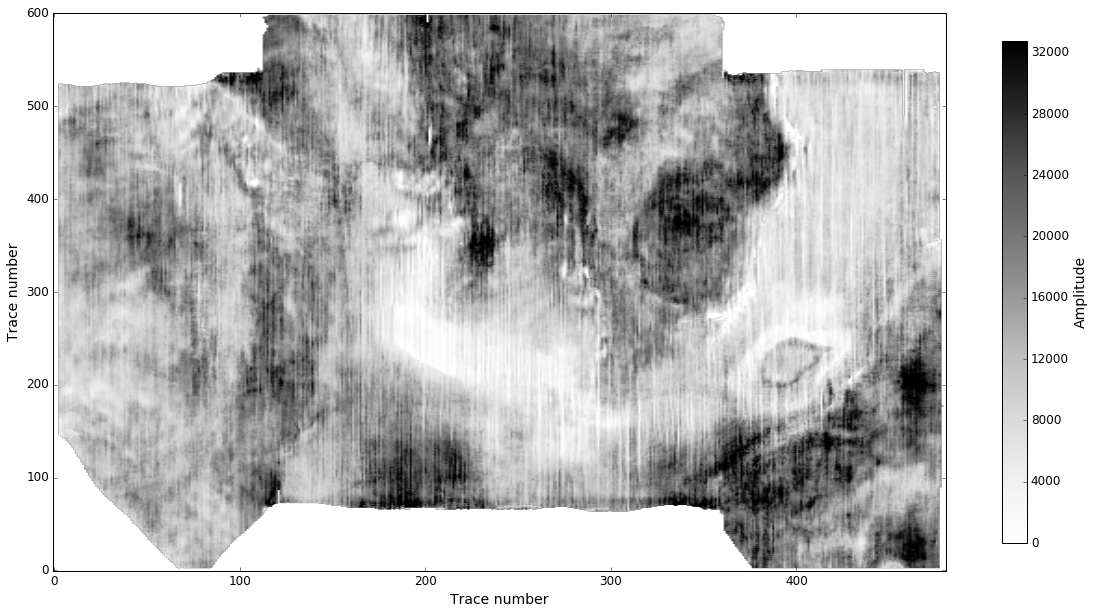

In [84]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# Draw
plt.imshow(amp_full, cmap='Greys', origin='lower', aspect=0.5, vmin=0)
ax.set_ylabel("Trace number", size=14)
ax.set_xlabel("Trace number", size=14)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12) 

# Colourbar
cbar = plt.colorbar(label="Amplitude", shrink=0.9)
cbar.ax.tick_params(labelsize=12) 
text = cbar.ax.yaxis.label
font = FontProperties(size=14)
text.set_font_properties(font)

# Save
plt.savefig(os.path.join(env['HOME'], "horizon_slice.png"), dpi=250, transparent=True)
plt.show()

And we can make some loops to iterate over all interpolation methods...

In [39]:
methods = ["cubic", "quadratic", "linear", "nearest", "zero"]

In [40]:
results = {}
for method in methods:
    results[method] = get_amp(seismic[:,line,:], horizon[line], method=method)

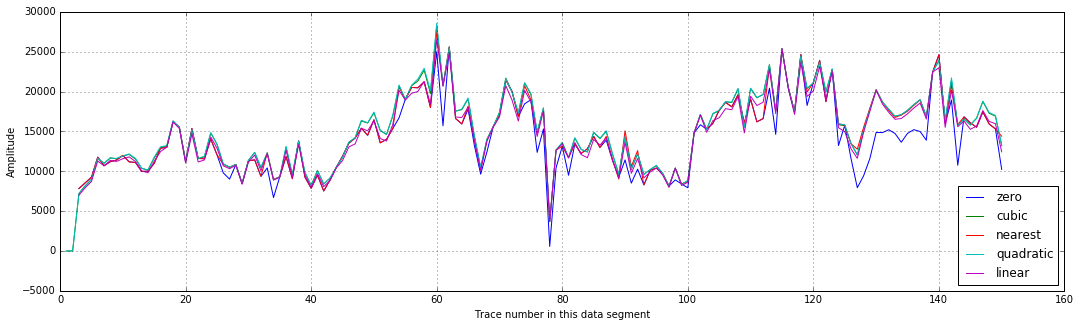

In [41]:
s1, s2 = 0, 151
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)
for method, data in results.items():
    ax.plot(data[s1:s2], label=method)
ax.set_xlabel("Trace number in this data segment")
ax.set_ylabel("Amplitude")
ax.legend(loc='lower right')
plt.grid()
plt.show()

### Figure for print

/Users/matt/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


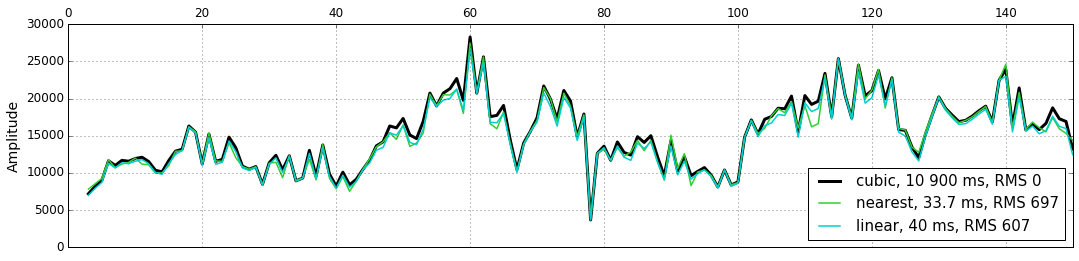

In [43]:
def rms(a):
    mean_squares = np.nansum(a**2.)/a.size
    return np.sqrt(mean_squares)

# Deal with edge
for m, d in results.items():
    d[d<1] = np.nan

s1, s2 = 0, 151
colours = {'linear': 'darkturquoise', 'nearest': 'limegreen', 'cubic': 'black'}
lw = {'linear': 1.5, 'nearest': 1.5, 'cubic': 3}
zorder = {'linear': 1, 'nearest': 1, 'cubic': 0}
labels = {'linear': 'linear, 40 ms, RMS {:.0f}', 'nearest': 'nearest, 33.7 ms, RMS {:.0f}', 'cubic': 'cubic, 10 900 ms, RMS 0'}

r = results.copy()
c = r.pop('cubic')

fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(111)
for m, data in results.items():
    if m in ['zero', 'quadratic']: continue
    diff = c - data
    ax.plot(data[s1:s2], c=colours[m], lw=lw[m], zorder=zorder[m], label=labels[m].format(rms(diff)))
ax.legend(loc='lower right', fontsize=15)
ax.set_ylabel("Amplitude", size=14)
ax.xaxis.tick_top()
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12)
plt.xlim(0, 150)
plt.grid()

plt.savefig(os.path.join(env['HOME'], "amplitude_extraction.png"), dpi=250)
plt.show()

## What's the difference?

In [44]:
for method in methods:
    print(method, end=', ')
    %timeit get_amp(seismic[:,line,:], horizon[line], method=method)

cubic, 1 loops, best of 3: 11 s per loop
quadratic, 1 loops, best of 3: 9.62 s per loop
linear, 10 loops, best of 3: 38.9 ms per loop
nearest, 10 loops, best of 3: 33.5 ms per loop
zero, 10 loops, best of 3: 54.3 ms per loop


Linear interpolation is over 200 times faster than cubic interpolation.

And we can look at the RMS 'error' (assuming the `cubic` result is the best one).

In [45]:
def rms(a):
    mean_squares = np.nansum(a**2.)/a.size
    return np.sqrt(mean_squares)

In [46]:
print("Mean RMS difference between cubic result and...")
r = results.copy()
c = r.pop('cubic')
for method, data in r.items():
    diff = c - data
    print("{}: {:.2f}".format(method, rms(diff)))

Mean RMS difference between cubic result and...
zero: 1892.13
nearest: 696.59
quadratic: 73.49
linear: 606.62


## Try a timeslice

We'll make a timeslice about half-way through the data, being careful to avoid an actual sample location — where all the interpolations would give the same result.

In [47]:
timeslice = np.zeros_like(horizon) + 124.5

In [48]:
results = {}
for method in methods:
    results[method] = get_amp(seismic[:,line,:], timeslice[line], method=method)

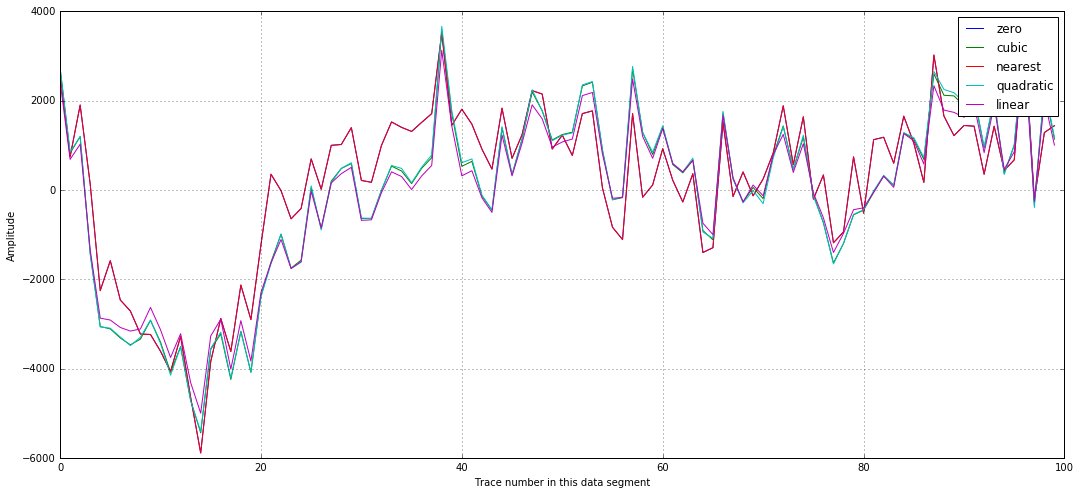

In [49]:
s1, s2 = 100, 200
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
for method, data in results.items():
    plt.plot(data[s1:s2], label=method)
ax.set_xlabel("Trace number in this data segment")
ax.set_ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [50]:
print("Mean RMS difference between cubic result and...")
r = results.copy()
c = r.pop('cubic')
for method, data in r.items():
    diff = c - data
    print("{}: {:.2f}".format(method, rms(diff)))

Mean RMS difference between cubic result and...
zero: 745.69
nearest: 745.69
quadratic: 49.52
linear: 170.25


## Spatial interpolation

What about spatially? We should also be able to interpolate in 3D, so we can extract amplitudes at arbitrary locations in the cube. 

For example, perhaps we'd like to extract amplitudes along a deviated wellbore. Let's make one...

In [51]:
from scipy.interpolate import splprep, splev
from mpl_toolkits.mplot3d import Axes3D

trajectory = np.array([[   0,   0,    0],
                       [   0,   0, -100],
                       [   0,   0, -200],
                       [   5,   0, -300],
                       [  10,  10, -400],
                       [  20,  20, -500],
                       [  40,  80, -650],
                       [ 160, 160, -700],
                       [ 600, 400, -800],
                       [1500, 960, -800]])

# Shift the 'well' to its tophole location.
trajectory[:,0] += 3000
trajectory[:,1] += 3000

# Fit the spline and fetch 400 points.
knees, _ = splprep(trajectory.T, s=3.0, k=3)
spline = splev(np.linspace(0, 1, 1000), knees)

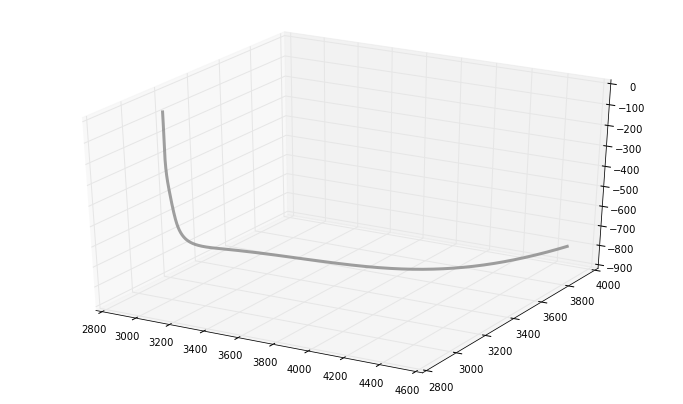

In [52]:
plt.figure(figsize=(12,7))
plt.gca(projection='3d')
plt.plot(*spline, color='grey', lw=3, alpha=0.75)
plt.show()

In [53]:
path = np.array(spline).T[::-1]

Now make an interpolating function for the 3D seismic volume. From this we can look up any coordinates. 

We need the seismic data in a different order from before...

In [54]:
seismic.shape

(251, 601, 481)

In [55]:
s = np.swapaxes(seismic, 0, 2)
s.shape

(481, 601, 251)

In [56]:
from scipy.interpolate import RegularGridInterpolator

# Make linear spaces in real-world units for the seismic domain.
x = np.linspace(0, 12000, 481) # m
y = np.linspace(0, 7500, 601)  # m
t = np.linspace(-1000, 0, 251)  # ms

f = RegularGridInterpolator((x, y, t), s)

In [57]:
amp_along_path = f(path)

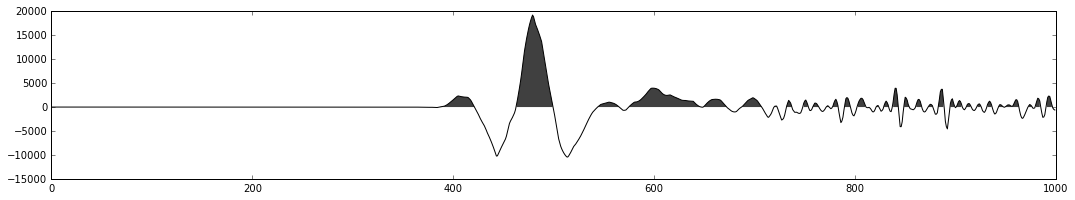

In [58]:
fig = plt.figure(figsize=(18,3))
ax = fig.add_subplot(111)
x = np.arange(1000)
ax.plot(amp_along_path, 'k')
ax.fill_between(x, 0, amp_along_path, where=amp_along_path>0, color='k', alpha=0.75, lw=0)
plt.show()

In [59]:
f([123, 456, -789])

array([-852.9604])

We could use this to extract along our horizon too, couldn't we? I just need to make a slightly different space — the original horizon we loaded is in zero-indexed 'inline, crossline, travel-time space'. So let's make that.

In [60]:
# We need the data in yet another order!
s = np.swapaxes(s, 0, 1)

x = np.linspace(1000, 1600, 601)  # Inline numbers
y = np.linspace(1000, 1480, 481)  # Crossline numbers
t = np.linspace(0, 1000, 251)  # ms

g = RegularGridInterpolator((x, y, t), s, method="nearest")  # or 'linear' (default)

We need (x, y) info in the horizon. That's ewhat we got when we loaded the data originally from the `txt` file! Now we don't mind that it had 'missing' traces.

In [61]:
horizon_data = np.loadtxt('data/Penobscot_Seabed.txt')
horizon_data

array([[ 1003.        ,  1067.        ,   155.92899919],
       [ 1003.        ,  1068.        ,   156.3333571 ],
       [ 1003.        ,  1069.        ,   157.37710893],
       ..., 
       [ 1597.        ,  1353.        ,   176.5011102 ],
       [ 1597.        ,  1354.        ,   177.92794108],
       [ 1597.        ,  1355.        ,   180.42777479]])

Copy this horizon, with its coordinates, then compute the interpolated amplitude values and replace the TWT values with the amplitudes.

In [62]:
amplitudes = np.copy(horizon_data)
amplitudes[:,2] = g(horizon_data)

In [63]:
%timeit g(horizon_data)

10 loops, best of 3: 51.1 ms per loop


For comparison, this took just over 20 seconds with my 'loop over 1D interpolations' function before. That's a speedup of over 300!

Now I just want the amplitude array as a regularized grid. Then we can manipulate and display it as normal.

In [64]:
amps = regularize_horizon(amplitudes, (601, 481), adj=(-1000, -1000))

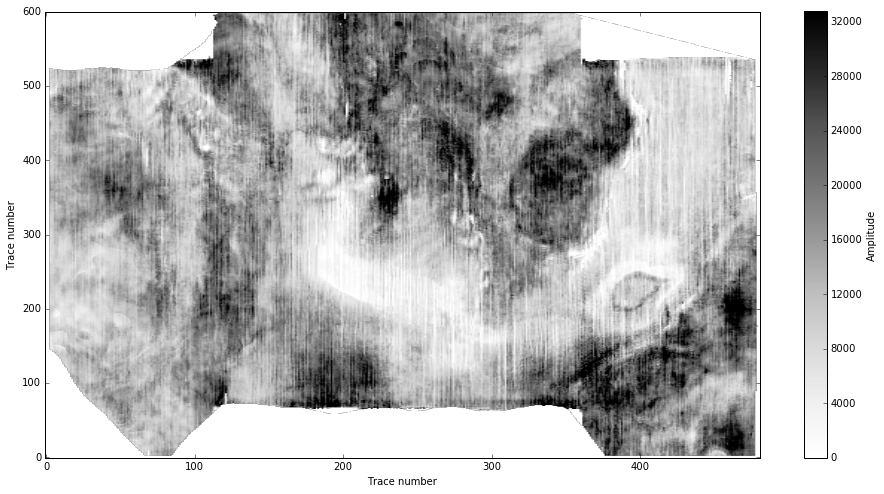

In [65]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plt.imshow(amps, cmap='Greys', origin='lower', aspect=0.5, vmin=0)
ax.set_ylabel("Trace number")
ax.set_xlabel("Trace number")
plt.colorbar(label="Amplitude")
plt.show()

<hr />

## Attributes from zones

To illustrate this part, we'll move onto some fake data.

Here's a horribly hacky function to generate a fake horizon. The components, `y0`, `y1`, etc., are strcture at different scales, which we then add together. The smart thing would be to do this in a loop for an arbitrary number of scales.

In [67]:
from scipy.interpolate import spline
def generate():
    x = np.linspace(0, 100, 101)

    x0 = np.linspace(0, 100, 3)
    y0 = np.random.random(3) * 3
    y0 = spline(x0, y0, x, order=2)
    
    x1 = np.linspace(0, 100, 10)
    y1 = np.random.random(10)
    y1 = spline(x1, y1, x)

    x2 = np.linspace(0, 100, 40)
    y2 = np.random.random(40)/10 - 0.05
    y2 = spline(x2, y2, x)

    y3 = np.random.random(101)/10 - 0.05

    return x, y0 + y1 + y2 + y3

Now we can generate two fake horizons, and turn them into something 'depthlike' for more intuitive visualization. In retrospect, this was probably not necessary...

In [68]:
x, h1 = generate()
_, h2 = generate()

h1 = -(20*h1 + 100)
h2 = -(20*h2 + 200)

Now I make a 'zone' around `h1`, and a function to generate proportional slices. I also include an average horizon, but we don't use that one because it's essentially like the middle porportional horizon.

In [69]:
h1_top = h1 + 25
h1_bot = h1 - 50

h_avg = (h1 + h2) / 2

def prop(p, t):
    t = float(t)
    return h1 - (p/t)*(h1-h2)

Now tie it all together in a plot.

In [70]:
def basic_plot(ax, x, h1, h2):
    ax.plot(h1, lw=2, color='g')
    ax.plot(h2, lw=2, color='g')
    ax.fill_between(x, 0, h1, facecolor='gray', alpha=0.33, lw=0)
    ax.fill_between(x, h2, -400, facecolor='gray', alpha=0.33, lw=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(-350,-50)
    return ax

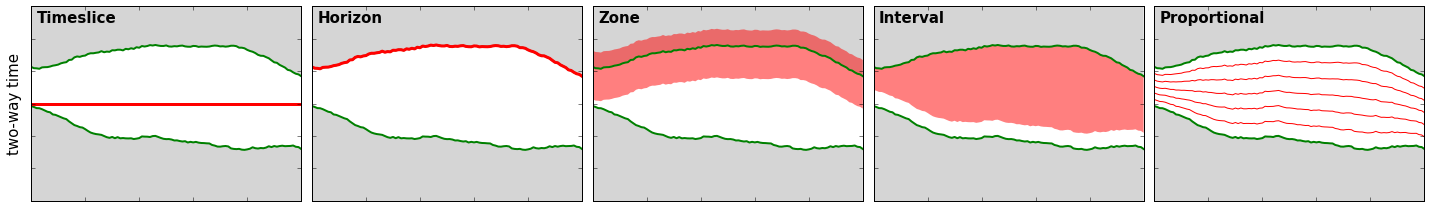

In [71]:
# Set up plot
fig = plt.figure(figsize=(20,3))

# Timeslice H1
ax0 = fig.add_subplot(151)
ax0 = basic_plot(ax0, x, h1, h2)
ax0.axhline(-200, color='r', lw=3)
ax0.set_ylabel('two-way time', size=15)
ax0.text(2, -75, 'Timeslice', size=15, weight="bold")

# Highlight H1
ax1 = fig.add_subplot(152)
ax1 = basic_plot(ax1, x, h1, h2)
ax1.plot(h1, lw=3, color='r')
ax1.text(2, -75, 'Horizon', size=15, weight="bold")

# Zone around H1
ax2 = fig.add_subplot(153)
ax2 = basic_plot(ax2, x, h1, h2)
ax2.plot(h1_top, lw=0)
ax2.plot(h1_bot, lw=0)
ax2.fill_between(x, h1_top, h1_bot, facecolor='r', alpha=0.5, lw=0)
ax2.text(2, -75, 'Zone', size=15, weight="bold")

# Between both (with shift maybe)
ax3 = fig.add_subplot(154)
ax3 = basic_plot(ax3, x, h1, h2)
ax3.fill_between(x, h1, h2+25, facecolor='r', alpha=0.5, lw=0)
ax3.text(2, -75, 'Interval', size=15, weight="bold")

# Proportional slicing
ax4 = fig.add_subplot(155)
ax4 = basic_plot(ax4, x, h1, h2)
slices = 5
for i in range(slices):
    ax4.plot(prop(i+1, slices+1), 'r')
ax4.text(2, -75, 'Proportional', size=15, weight="bold")

# Display
plt.tight_layout()
#plt.savefig('/home/matt/horizons.png', dpi=150)
plt.show()

<hr />
## Different statistics from a zone

First restore the made-up data.

In [80]:
trace = np.array([0,1,3,0,-2,-5,-2,2,5,0,-1,1,0,3,3,-1,-3,-5,-1,0])
x = np.arange(trace.size)
t = np.linspace(0, trace.size-1, 2000)
amp_spline = read_amp(trace, t, method='cubic')

Compute some statistics.

In [72]:
mean_amp = np.mean(amp_spline); mean_amp

-0.094717415224682924

In [73]:
rms_amp = rms(amp_spline); rms_amp

2.5751742070160328

In [74]:
avg_abs_amp = np.mean(abs(amp_spline)); avg_abs_amp

2.0710879920907597

In [75]:
max_amp = np.amax(amp_spline); max_amp

5.0786960252597613

We should also compute the Hilbert transform for a phase-independent amplitude 'envelope'. This is sometimes called 'relfection strength' or 'energy'.

In [76]:
import scipy.signal
h = scipy.signal.hilbert(amp_spline)
avg_h = np.mean(np.abs(h))
max_h = np.amax(np.abs(h)); max_h

5.2380527855403978

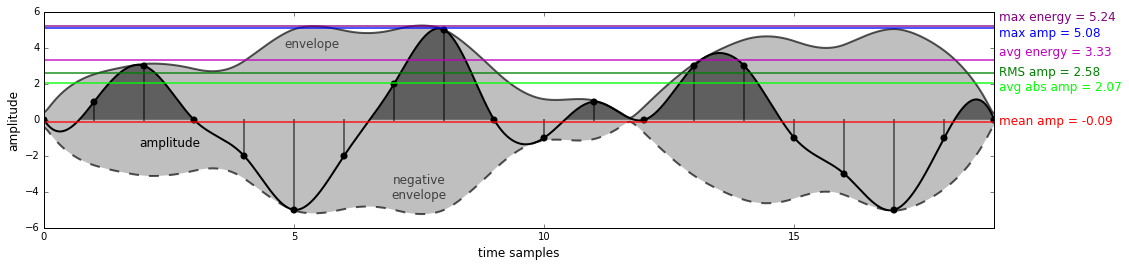

In [81]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_axes([0.05,0.15,0.825,0.75])
ax.scatter(x, trace, s=50, c='k', lw=0)
ax.fill_between(t, 0, amp_spline, where=amp_spline>0, color='k', alpha=0.5, lw=0)
for i, v in enumerate(trace):
    if v > 0:
        ax.axvline(x=i, ymin=0.5, ymax=0.5 + v/12., c='k', lw=2, alpha=0.5)
    else:
        ax.axvline(x=i, ymin=0.5 + v/12., ymax=0.5, c='k', lw=2, alpha=0.5)
ax.plot(t, amp_spline, 'k', lw=2)
abs_h = np.abs(h)
ax.plot(t, abs_h, 'k', lw=2, alpha=0.67)
line, = ax.plot(t, -abs_h, 'k--', lw=2, alpha=0.67)
line.set_dashes([10,10])
ax.fill_between(t, -abs_h, abs_h, color='k', alpha=0.25, lw=0)
        
# Add the mean and the RMS
linestyle = {'lw':2, 'alpha':0.67}
ax.axhline(mean_amp, color='r', **linestyle)
ax.axhline(rms_amp, color='g', **linestyle)
ax.axhline(avg_abs_amp, color='lime', **linestyle)
ax.axhline(max_amp, color='b', **linestyle)
ax.axhline(avg_h, color='m', **linestyle)
ax.axhline(max_h, color='purple', **linestyle)

# Add some labels
pos = 19.1
styles = {'ha':'left', 'va':'center', 'size':12}
ax.text(1.9, -1.3, "amplitude", color='k', **styles)
ax.text(4.8, 4.2, "envelope", color='k', alpha=0.67, **styles)
ax.text(7.5, -4.4, "negative\nenvelope", color='k', alpha=0.67, ha='center', size=12)
ax.text(pos, mean_amp, "mean amp = {:.2f}".format(mean_amp), color='r', **styles)
ax.text(pos, rms_amp+0.1, "RMS amp = {:.2f}".format(rms_amp), color='g', **styles)
ax.text(pos, avg_abs_amp-0.25, "avg abs amp = {:.2f}".format(avg_abs_amp), color='lime', **styles)
ax.text(pos, max_amp-0.25, "max amp = {:.2f}".format(max_amp), color='b', **styles)
ax.text(pos, avg_h+0.45, "avg energy = {:.2f}".format(avg_h), color='m', **styles)
ax.text(pos, max_h+0.45, "max energy = {:.2f}".format(max_h), color='purple', **styles)
ax.set_xlim(0, 19)
plt.xlabel('time samples', size=12)
plt.ylabel('amplitude', size=12)

#plt.savefig('/home/matt/trace_stats.png', dpi=150)
plt.show()

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:left;" width="50px" /><p style="color:gray; float:left; margin-left:12px;">Code and text © 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;<br>Data: Penobscot, licensed CC-BY-SA, Nova Scotia Department of Energy https://opendtect.org/osr/. </p>